In [1]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess
import json
import csv
import getpass
import os
import sys

In [2]:
e2e_folder = "../../../../test/e2e/"
loadtime_folder = "../../../../test/loadtime/"
output_folder = "./csv/"
img_folder = "./imgs/"

In [5]:
sudo_password = getpass.getpass("Enter sudo password: ")
subprocess.run(["sudo", "-S", "echo", "test"], input=sudo_password.encode())

Enter sudo password:  ········


test


[sudo] password for mnguyen1: 

CompletedProcess(args=['sudo', '-S', 'echo', 'test'], returncode=0)

In [7]:
rates = [2, 10, 20, 30, 40, 50, 80, 100]
print(rates)
timeout = 200
base_config = f"{e2e_folder}/networks/epoch.toml"
modified_config = f"{e2e_folder}/networks/simple_modified.toml"
aggregate_file = "./csv/aggregated_out.csv"

# Clear old aggregate file
if os.path.exists(aggregate_file):
    os.remove(aggregate_file)

# Run experiments
for i, rate in enumerate(rates):
    print(f"Running test with load_tx_batch_size = {rate}")

    # Modify the config file
    with open(base_config, "r") as src, open(modified_config, "w") as dst:
        for line in src:
            if line.startswith("load_tx_batch_size"):
                dst.write(f"load_tx_batch_size = {rate}\n")
            else:
                dst.write(line)

    # Run the test
    test_cmd =f"{e2e_folder}build/runner -p -f {modified_config} benchmark"
    stop_cmd = f"{e2e_folder}build/runner -p -f {modified_config} stop"

    subprocess.run(test_cmd, shell=True)
    subprocess.run(stop_cmd, shell=True)

    report_cmd = [
        "sudo", "-S",
        f"{loadtime_folder}/build/report",
        "--database-type", "goleveldb",
        "--data-dir", f"{e2e_folder}/networks/simple_modified/validator00/data",
        "--csv", f"{output_folder}/out_{rate}.csv"
    ]
    print(report_cmd)
    subprocess.run(report_cmd, timeout=60)

    print("-------- Aggregating results...")
    with open(f"{output_folder}/out_{rate}.csv", "r") as infile, open(aggregate_file, "a") as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        for j, row in enumerate(reader):
            if i == 0 and j == 0:
                writer.writerow(row)  # header
            elif j > 0:
                row[0] = f"{rate}"  # update experiment_id
                writer.writerow(row)


[2, 10, 20, 30, 40, 50, 80, 100]
Running test with load_tx_batch_size = 2
I[2025-08-24|18:07:10.505] Removing Docker containers and networks      
I[2025-08-24|18:07:10.563] cleanup dir                                  msg="Removing testnet directory `../../../../test/e2e//networks/simple_modified`"
I[2025-08-24|18:07:14.146] setup                                        msg="Generating testnet files in `../../../../test/e2e//networks/simple_modified`"
I[2025-08-24|18:07:14.716] Starting initial network nodes...            
I[2025-08-24|18:07:14.716] load                                         msg="Starting transaction load (16 workers)..."
E[2025-08-24|18:07:14.718] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5704/v1\": dial tcp 127.0.0.1:5704: connect: connection refused"
E[2025-08-24|18:07:14.718] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5710/v1\": dial tcp 127.0.0.1:5710: connect: connect

INFO	Reading ./csv/aggregated_out.csv...
INFO	Found experiment 2 with rate=2, connections=1
INFO	Found experiment 10 with rate=10, connections=1
INFO	Found experiment 20 with rate=20, connections=1
INFO	Found experiment 30 with rate=30, connections=1
INFO	Found experiment 40 with rate=40, connections=1
INFO	Found experiment 50 with rate=50, connections=1
INFO	Found experiment 80 with rate=80, connections=1
INFO	Found experiment 100 with rate=100, connections=1
INFO	For 1 connection(s): throughput rate = 1.995761 tx/s	average latency = 1.882352s
INFO	For 1 connection(s): throughput rate = 9.995742 tx/s	average latency = 1.965219s
INFO	For 1 connection(s): throughput rate = 19.952105 tx/s	average latency = 1.909384s
INFO	For 1 connection(s): throughput rate = 29.892403 tx/s	average latency = 2.028143s
INFO	For 1 connection(s): throughput rate = 39.837737 tx/s	average latency = 2.101418s
INFO	For 1 connection(s): throughput rate = 49.847279 tx/s	average latency = 2.109055s
INFO	For 1 conn

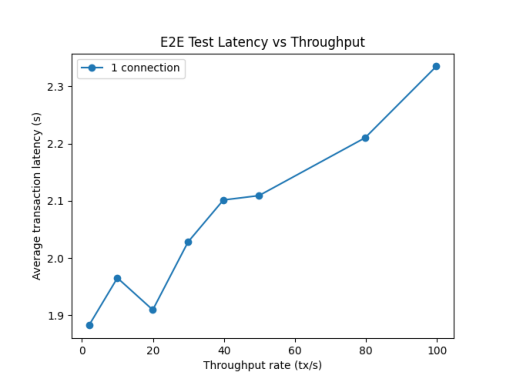

In [8]:
plot_cmd = [
    sys.executable, "../latency_throughput.py",
    "-t", "E2E Test Latency vs Throughput",
    f"{img_folder}/e2e_latency_plot.png",
    f"{output_folder}aggregated_out.csv"
]
subprocess.run(plot_cmd)

# show image of the plot
plt.imshow(plt.imread(f"{img_folder}/e2e_latency_plot.png"))
plt.axis('off')
plt.show()